# Building a Research Agent using LangGraph (for graph-based workflows), GPT-4o (LLM), RAG (for knowledge retrieval), Pinecone (vector DB), ArXiv (research source), and SerpAPI (web search).
---

In [29]:
from dotenv import load_dotenv, find_dotenv

# Load the API keys from .env
load_dotenv(find_dotenv(), override=True)

True

## 01: Extracting Data from ArXiv into a Pandas DataFrame and Saving it as JSON

In [3]:
import arxiv
import pandas as pd
import json
import os

def extract_from_arxiv(search_query='cat:cs.AI', max_results=100, json_file_path='../files/arxiv_dataset.json'):
    # Ensure the directory exists
    os.makedirs(os.path.dirname(json_file_path), exist_ok=True)

    client = arxiv.Client()
    search = arxiv.Search(
        query=search_query,
        max_results=max_results,
        sort_by=arxiv.SortCriterion.SubmittedDate  # Sort by recent
    )

    results = list(client.results(search))

    papers = []
    for result in results:
        papers.append({
            'title': result.title,
            'summary': result.summary,
            'authors': [author.name for author in result.authors],
            'arxiv_id': result.entry_id.split('/')[-1],
            'url': result.entry_id,
            'pdf_link': result.pdf_url
        })

    df = pd.DataFrame(papers)

    # Save to JSON
    with open(json_file_path, 'w', encoding='utf-8') as f:
        json.dump(papers, f, ensure_ascii=False, indent=4)
        print(f'Data saved to {json_file_path} ...')

    return df

In [4]:
# Example usage
df = extract_from_arxiv(max_results=5)

Data saved to ../files/arxiv_dataset.json ...


In [6]:
print(df.head(2))

                                               title  \
0  BLAZER: Bootstrapping LLM-based Manipulation A...   
1  NovaFlow: Zero-Shot Manipulation via Actionabl...   

                                             summary  \
0  Scaling data and models has played a pivotal r...   
1  Enabling robots to execute novel manipulation ...   

                                             authors      arxiv_id  \
0  [Rocktim Jyoti Das, Harsh Singh, Diana Turmakh...  2510.08572v1   
1  [Hongyu Li, Lingfeng Sun, Yafei Hu, Duy Ta, Je...  2510.08568v1   

                                 url                           pdf_link  
0  http://arxiv.org/abs/2510.08572v1  http://arxiv.org/pdf/2510.08572v1  
1  http://arxiv.org/abs/2510.08568v1  http://arxiv.org/pdf/2510.08568v1  


In [5]:
import json
file_name = '../files/arxiv_dataset.json'
with  open(file_name, 'r') as file:
    data = json.load(file)

print(data)

[{'title': 'BLAZER: Bootstrapping LLM-based Manipulation Agents with Zero-Shot Data Generation', 'summary': "Scaling data and models has played a pivotal role in the remarkable progress\nof computer vision and language. Inspired by these domains, recent efforts in\nrobotics have similarly focused on scaling both data and model size to develop\nmore generalizable and robust policies. However, unlike vision and language,\nrobotics lacks access to internet-scale demonstrations across diverse robotic\ntasks and environments. As a result, the scale of existing datasets typically\nsuffers from the need for manual data collection and curation. To address this\nproblem, here we propose BLAZER, a framework that learns manipulation policies\nfrom automatically generated training data. We build on the zero-shot\ncapabilities of LLM planners and automatically generate demonstrations for\ndiverse manipulation tasks in simulation. Successful examples are then used to\nfinetune an LLM and to improve 

In [7]:
import pandas as pd
df = pd.DataFrame(data)
df.sample(n=3)

,title,summary,authors,arxiv_id,url,pdf_link
1,NovaFlow: Zero-Shot Manipulation via Actionabl...,Enabling robots to execute novel manipulation ...,"[Hongyu Li, Lingfeng Sun, Yafei Hu, Duy Ta, Je...",2510.08568v1,http://arxiv.org/abs/2510.08568v1,http://arxiv.org/pdf/2510.08568v1
0,BLAZER: Bootstrapping LLM-based Manipulation A...,Scaling data and models has played a pivotal r...,"[Rocktim Jyoti Das, Harsh Singh, Diana Turmakh...",2510.08572v1,http://arxiv.org/abs/2510.08572v1,http://arxiv.org/pdf/2510.08572v1
3,MATRIX: Multimodal Agent Tuning for Robust Too...,Vision language models (VLMs) are increasingly...,"[Tajamul Ashraf, Umair Nawaz, Abdelrahman M. S...",2510.08567v1,http://arxiv.org/abs/2510.08567v1,http://arxiv.org/pdf/2510.08567v1


## 02 - Downloading the Research Papers (PDFs)

In [8]:
import pandas as pd
import requests
import os
from tqdm import tqdm  # for progress bar

def download_pdfs(df, download_folder='files'):
    """
    Downloads PDFs from URLs listed in the DataFrame and saves them to a specified folder.
    Adds a 'pdf_file_name' column with the local file paths or None if download failed.

    Args:
        df (pd.DataFrame): Must contain a 'pdf_link' column with valid arXiv PDF URLs.
        download_folder (str): Folder where PDFs will be stored (default: 'files').

    Returns:
        pd.DataFrame: Updated DataFrame with 'pdf_file_name' column.
    """

    # Create directory if not exists
    os.makedirs(download_folder, exist_ok=True)

    pdf_file_names = []

    # Use tqdm for progress visualization (optional but nice)
    for index, row in tqdm(df.iterrows(), total=len(df), desc="Downloading PDFs"):
        pdf_link = row.get('pdf_link')

        if not pdf_link or not isinstance(pdf_link, str):
            pdf_file_names.append(None)
            continue

        # Safer filename: use arxiv_id instead of URL fragment
        arxiv_id = pdf_link.split('/')[-1].replace('.pdf', '')
        file_path = os.path.join(download_folder, f"{arxiv_id}.pdf")

        # Skip download if file already exists
        if os.path.exists(file_path):
            pdf_file_names.append(file_path)
            continue

        try:
            # Stream download to handle large files
            with requests.get(pdf_link, stream=True, timeout=30) as response:
                response.raise_for_status()
                with open(file_path, 'wb') as f:
                    for chunk in response.iter_content(chunk_size=8192):
                        if chunk:
                            f.write(chunk)
            pdf_file_names.append(file_path)
            print(f"Downloaded: {file_path}")

        except requests.exceptions.RequestException as e:
            print(f"Failed to download {pdf_link}: {e}")
            pdf_file_names.append(None)

    df['pdf_file_name'] = pdf_file_names
    return df

In [9]:
df = download_pdfs(df, download_folder='../files/pdfs')

Downloaded: ../files/pdfs/2510.08572v1.pdf


Downloaded: ../files/pdfs/2510.08568v1.pdf


Downloaded: ../files/pdfs/2510.08569v1.pdf


Downloaded: ../files/pdfs/2510.08567v1.pdf


Downloaded: ../files/pdfs/2510.08564v1.pdf


In [13]:
df.head(n=3)

,title,summary,authors,arxiv_id,url,pdf_link,pdf_file_name
0,BLAZER: Bootstrapping LLM-based Manipulation A...,Scaling data and models has played a pivotal r...,"[Rocktim Jyoti Das, Harsh Singh, Diana Turmakh...",2510.08572v1,http://arxiv.org/abs/2510.08572v1,http://arxiv.org/pdf/2510.08572v1,../files/pdfs/2510.08572v1.pdf
1,NovaFlow: Zero-Shot Manipulation via Actionabl...,Enabling robots to execute novel manipulation ...,"[Hongyu Li, Lingfeng Sun, Yafei Hu, Duy Ta, Je...",2510.08568v1,http://arxiv.org/abs/2510.08568v1,http://arxiv.org/pdf/2510.08568v1,../files/pdfs/2510.08568v1.pdf
2,ArenaBencher: Automatic Benchmark Evolution vi...,Benchmarks are central to measuring the capabi...,"[Qin Liu, Jacob Dineen, Yuxi Huang, Sheng Zhan...",2510.08569v1,http://arxiv.org/abs/2510.08569v1,http://arxiv.org/pdf/2510.08569v1,../files/pdfs/2510.08569v1.pdf


## 03 - Loading and Splitting PDF Files into Chunks, Expanding the DataFrame

In [17]:
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
import os

def load_and_chunk_pdf(pdf_file_name: str, chunk_size: int = 512, chunk_overlap: int = 64):
    """
    Loads a PDF file and splits its content into manageable text chunks.

    Args:
        pdf_file_name (str): Path to the PDF file to load.
        chunk_size (int): Maximum size (in characters) of each chunk. Default is 512.
        chunk_overlap (int): Overlap between chunks to preserve context. Default is 64.

    Returns:
        List[Document]: A list of LangChain Document objects containing text chunks.
    """

    if not os.path.exists(pdf_file_name):
        raise FileNotFoundError(f"File not found: {pdf_file_name}")

    print(f"Loading and chunking: {pdf_file_name}")

    # Load PDF
    loader = PyPDFLoader(pdf_file_name)
    try:
        data = loader.load()
    except Exception as e:
        print(f"Failed to load {pdf_file_name}: {e}")
        return []

    if not data:
        print(f"No text extracted from {pdf_file_name}")
        return []

    # Split into chunks
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=["\n\n", "\n", ".", "!", "?", " ", ""]
    )

    chunks = text_splitter.split_documents(data)
    print(f"Split into {len(chunks)} chunks from {pdf_file_name}")

    return chunks

In [20]:
# Example Usage
pdf_path ='../files/pdfs/2510.08564v1.pdf'
chunks = load_and_chunk_pdf(pdf_path, chunk_size=800, chunk_overlap=100)

print(f"First chunk:\n{chunks[0].page_content[:300]}...")

Loading and chunking: ../files/pdfs/2510.08564v1.pdf


Split into 170 chunks from ../files/pdfs/2510.08564v1.pdf
First chunk:
HOWTOTEACHLARGEMULTIMODALMODELS
NEWSKILLS?
Zhen Zhu, Yiming Gong∗, Yao Xiao, Yaoyao Liu & Derek Hoiem
University of Illinois Urbana-Champaign
Champaign, IL, USA
{zhenzhu4,yimingg8,yaox11,lyy,dhoiem}@illinois.edu
ABSTRACT
How can we teach large multimodal models (LMMs) new skills without erasing
prio...


In [ ]:
import pandas as pd
from tqdm import tqdm

def expand_df(df, chunk_size=512, chunk_overlap=64):
    """
    Expands each row in the DataFrame by splitting PDF documents into text chunks.
    Each resulting row corresponds to a chunk with metadata for linking to adjacent chunks.

    Args:
        df (pd.DataFrame): Must contain at least:
            ['pdf_file_name', 'arxiv_id', 'title', 'summary', 'authors', 'url']
        chunk_size (int): Max characters per chunk (default: 512)
        chunk_overlap (int): Overlap between chunks (default: 64)

    Returns:
        pd.DataFrame: Expanded DataFrame with one row per text chunk.
    """

    expanded_rows = []

    # Use tqdm for progress tracking
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Expanding PDFs"):
        pdf_path = row.get("pdf_file_name")

        if not pdf_path or not isinstance(pdf_path, str):
            print(f"Skipping row {idx}: missing or invalid 'pdf_file_name'")
            continue

        try:
            chunks = load_and_chunk_pdf(pdf_path, chunk_size=chunk_size, chunk_overlap=chunk_overlap)
        except Exception as e:
            print(f"Error processing {pdf_path}: {e}")
            continue

        if not chunks:
            print(f"No chunks extracted from {pdf_path}")
            continue

        # Build chunk-level entries
        for i, chunk in enumerate(chunks):
            expanded_rows.append({
                "id": f"{row['arxiv_id']}#{i}",  # unique per chunk
                "title": row.get("title", ""),
                "summary": row.get("summary", ""),
                "authors": row.get("authors", []),
                "arxiv_id": row.get("arxiv_id", ""),
                "url": row.get("url", ""),
                "chunk": chunk.page_content.strip(),
                "prechunk_id": f"{row['arxiv_id']}#{i-1}" if i > 0 else "",
                "postchunk_id": f"{row['arxiv_id']}#{i+1}" if i < len(chunks) - 1 else ""
            })

    expanded_df = pd.DataFrame(expanded_rows)
    print(f"Expanded into {len(expanded_df)} chunks from {len(df)} documents.")
    return expanded_df

In [23]:
# Example Usage
expanded_df = expand_df(df, chunk_size=800, chunk_overlap=100)

expanded_df.head(3)

Expanding PDFs:   0%|          | 0/5 [00:00<?, ?it/s]

Loading and chunking: ../files/pdfs/2510.08572v1.pdf


Expanding PDFs:  20%|██        | 1/5 [00:00<00:02,  1.44it/s]

Split into 73 chunks from ../files/pdfs/2510.08572v1.pdf
Loading and chunking: ../files/pdfs/2510.08568v1.pdf


Expanding PDFs:  40%|████      | 2/5 [00:02<00:03,  1.33s/it]

Split into 96 chunks from ../files/pdfs/2510.08568v1.pdf
Loading and chunking: ../files/pdfs/2510.08569v1.pdf


Expanding PDFs:  60%|██████    | 3/5 [00:02<00:01,  1.06it/s]

Split into 91 chunks from ../files/pdfs/2510.08569v1.pdf
Loading and chunking: ../files/pdfs/2510.08567v1.pdf


Expanding PDFs:  80%|████████  | 4/5 [00:05<00:01,  1.45s/it]

Split into 198 chunks from ../files/pdfs/2510.08567v1.pdf
Loading and chunking: ../files/pdfs/2510.08564v1.pdf


Expanding PDFs: 100%|██████████| 5/5 [00:06<00:00,  1.26s/it]

Split into 170 chunks from ../files/pdfs/2510.08564v1.pdf
Expanded into 628 chunks from 5 documents.


,id,title,summary,authors,arxiv_id,url,chunk,prechunk_id,postchunk_id
0,2510.08572v1#0,BLAZER: Bootstrapping LLM-based Manipulation A...,Scaling data and models has played a pivotal r...,"[Rocktim Jyoti Das, Harsh Singh, Diana Turmakh...",2510.08572v1,http://arxiv.org/abs/2510.08572v1,BLAZER: Bootstrapping LLM-based Manipulation A...,,2510.08572v1#1
1,2510.08572v1#1,BLAZER: Bootstrapping LLM-based Manipulation A...,Scaling data and models has played a pivotal r...,"[Rocktim Jyoti Das, Harsh Singh, Diana Turmakh...",2510.08572v1,http://arxiv.org/abs/2510.08572v1,from the need for manual data collection and c...,2510.08572v1#0,2510.08572v1#2
2,2510.08572v1#2,BLAZER: Bootstrapping LLM-based Manipulation A...,Scaling data and models has played a pivotal r...,"[Rocktim Jyoti Das, Harsh Singh, Diana Turmakh...",2510.08572v1,http://arxiv.org/abs/2510.08572v1,"and real environments. Moreover, BLAZER improv...",2510.08572v1#1,2510.08572v1#3


## 04 - Building a Knowledge Base for the RAG System Using Embedding

In [27]:
import os
from getpass import getpass
from semantic_router.encoders import OpenAIEncoder

def initialize_encoder(model_name: str = "text-embedding-3-small"):
    """
    Initializes the OpenAI encoder for text embeddings, ensuring API key security.

    Args:
        model_name (str): The name of the OpenAI embedding model to use.
                          Options include 'text-embedding-3-small' or 'text-embedding-3-large'.

    Returns:
        OpenAIEncoder: Initialized encoder instance ready for generating embeddings.
    """
    # Ensure API key is securely loaded
    if not os.getenv("OPENAI_API_KEY"):
        os.environ["OPENAI_API_KEY"] = getpass("Enter your OpenAI API key: ")

    # Initialize encoder
    encoder = OpenAIEncoder(name=model_name)
    print(f"Encoder initialized with model: {model_name}")
    return encoder

In [30]:
# Example usage
encoder = initialize_encoder("text-embedding-3-small")
encoder('hello, how are you?')

Encoder initialized with model: text-embedding-3-small


[[0.013684329576790333,
  0.006457979325205088,
  0.01937759667634964,
  0.030178703367710114,
  0.015191800892353058,
  0.0020563083235174417,
  -0.0031850826926529408,
  0.05090278014540672,
  -0.015411335974931717,
  -0.04999537020921707,
  0.012872051447629929,
  -0.001522107282653451,
  -0.07101215422153473,
  -0.004562662914395332,
  0.024514708667993546,
  0.012937911786139011,
  -0.023973189294338226,
  -0.003260090248659253,
  0.014233166351914406,
  0.04150669276714325,
  -0.02092897519469261,
  0.03369125723838806,
  0.041155438870191574,
  0.03928207606077194,
  0.007361730094999075,
  -0.009432674385607243,
  -0.010515712201595306,
  -0.01399899646639824,
  0.02890540286898613,
  -0.015572328120470047,
  0.034745026379823685,
  -0.032754577696323395,
  0.02717839553952217,
  -0.02918347902595997,
  -0.007720303721725941,
  0.044111840426921844,
  -0.04935140162706375,
  0.04329224303364754,
  -0.02691495418548584,
  0.022802338004112244,
  -0.010281541384756565,
  0.000187

## 05 - Creating a Pinecone Index

In [ ]:
from pinecone import Pinecone, ServerlessSpec

# Check if 'PINECONE_API_KEY' is set; prompt if not
api_key = os.getenv('PINECONE_API_KEY') or getpass('Pinecone API key: ')

# Initialize the Pinecone client
pc = Pinecone(api_key=api_key)

# Define the serverless specification for Pinecone (AWS region 'us-east-1')
spec = ServerlessSpec(
    cloud='aws',
    region='us-east-1'
)

In [32]:
import time

# Define the name of the index
index_name = 'langgraph-research-agent'
dims = 1536  # Dimension for 'text-embedding-3-small'

# Check if the index exists; create it if it doesn't
if index_name not in pc.list_indexes().names():
    pc.create_index(
        index_name,
        dimension=dims,  # Embedding dimension (1536)
        metric='cosine',
        spec=spec  # Cloud provider and region specification
    )

    # Wait until the index is fully initialized
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)

# Connect to the index
index = pc.Index(index_name)

# Add a short delay before checking the stats
time.sleep(1)

# View the index statistics
index.describe_index_stats()


{'dimension': 1536,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {},
 'total_vector_count': 0,
 'vector_type': 'dense'}

## 06 - Populating the Knowledge Base and Uploading it to Pinecone

In [33]:
from tqdm.auto import tqdm

data = expanded_df
batch_size = 64  # Set batch size

# Loop through the data in batches, using tqdm for a progress bar
for i in tqdm(range(0, len(data), batch_size)):
    i_end = min(len(data), i + batch_size)  # Define batch endpoint
    batch = data[i:i_end].to_dict(orient='records')  # Slice data into a batch

    # Extract metadata for each chunk in the batch
    metadata = [{
        'arxiv_id': r['arxiv_id'],
        'title': r['title'],
        'chunk': r['chunk'],
    } for r in batch]

    # Generate unique IDs for each chunk
    ids = [r['id'] for r in batch]

    # Extract the chunk content
    chunks = [r['chunk'] for r in batch]

    # Convert chunks into embeddings
    embeds = encoder(chunks)

    # Upload embeddings, IDs, and metadata to Pinecone
    index.upsert(vectors=zip(ids, embeds, metadata))

# Display the index statistics.
index.describe_index_stats()

100%|██████████| 10/10 [00:49<00:00,  4.94s/it]


{'dimension': 1536,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'': {'vector_count': 628}},
 'total_vector_count': 628,
 'vector_type': 'dense'}

## LangGraph

## 07 - (a) Implementing the ArXiv Fetch Tool

In [34]:
import requests
# Specify the arXiv ID for the paper
arxiv_id = '1706.03762'

# Make a GET request to retrieve the page for the specified paper
res = requests.get(f'https://arxiv.org/abs/{arxiv_id}')

# Access the content of the response as a string (HTML)
res.text

'<!DOCTYPE html>\n<html lang="en">\n\n<head>  <title>[1706.03762] Attention Is All You Need</title>\n  <meta name="viewport" content="width=device-width, initial-scale=1">\n  <link rel="apple-touch-icon" sizes="180x180" href="/static/browse/0.3.4/images/icons/apple-touch-icon.png">\n  <link rel="icon" type="image/png" sizes="32x32" href="/static/browse/0.3.4/images/icons/favicon-32x32.png">\n  <link rel="icon" type="image/png" sizes="16x16" href="/static/browse/0.3.4/images/icons/favicon-16x16.png">\n  <link rel="manifest" href="/static/browse/0.3.4/images/icons/site.webmanifest">\n  <link rel="mask-icon" href="/static/browse/0.3.4/images/icons/safari-pinned-tab.svg" color="#5bbad5">\n  <meta name="msapplication-TileColor" content="#da532c">\n  <meta name="theme-color" content="#ffffff">\n  <link rel="stylesheet" type="text/css" media="screen" href="/static/browse/0.3.4/css/arXiv.css?v=20241206" />\n  <link rel="stylesheet" type="text/css" media="print" href="/static/browse/0.3.4/css/a

In [35]:
import re

# Compile a regular expression pattern to find the abstract in the HTML response
abstract_pattern = re.compile(
    r'<blockquote class="abstract mathjax">\s*<span class="descriptor">Abstract:</span>\s*(.*?)\s*</blockquote>',
    re.DOTALL
)

# Search for the abstract in the HTML response text
re_match = abstract_pattern.search(res.text)

# Check if the abstract was found and print it; otherwise, display an error message
if re_match:
    print(re_match.group(1))
else:
    print('Abstract not found.')

The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two machine translation tasks show these models to be superior in quality while being more parallelizable and requiring significantly less time to train. Our model achieves 28.4 BLEU on the WMT 2014 English-to-German translation task, improving over the existing best results, including ensembles by over 2 BLEU. On the WMT 2014 English-to-French translation task, our model establishes a new single-model state-of-the-art BLEU score of 41.8 after training for 3.5 days on eight GPUs, a small fraction of the training costs of the best models from the literature. We show that the Transforme

In [36]:
from langchain_core.tools import tool
import requests
import re

# Compile a regular expression pattern to find the abstract in the HTML response
abstract_pattern = re.compile(
    r'<blockquote class="abstract mathjax">\s*<span class="descriptor">Abstract:</span>\s*(.*?)\s*</blockquote>',
    re.DOTALL
)

@tool('fetch_arxiv')
def fetch_arxiv(arxiv_id: str) -> str:
    '''Fetches the abstract from an ArXiv paper given its ArXiv ID.

    Args:
        arxiv_id (str): The ArXiv paper ID.

    Returns:
        str: The extracted abstract text from the ArXiv paper.
    '''

    res = requests.get(f'https://arxiv.org/abs/{arxiv_id}')

    re_match = abstract_pattern.search(res.text)

    return re_match.group(1) if re_match else 'Abstract not found.'


In [ ]:
# Defining the ArXiv paper ID and invoking the tool with that ID.
arxiv_id = '1706.03762'
output = fetch_arxiv.invoke(input={'arxiv_id': arxiv_id})
print(output)

/workspaces/ResearchAgent/venv/lib/python3.12/site-packages/langsmith/client.py:290: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two machine translation tasks show these models to be superior in quality while being more parallelizable and requiring significantly less time to train. Our model achieves 28.4 BLEU on the WMT 2014 English-to-German translation task, improving over the existing best results, including ensembles by over 2 BLEU. On the WMT 2014 English-to-French translation task, our model establishes a new single-model state-of-the-art BLEU score of 41.8 after training for 3.5 days on eight GPUs, a small fraction of the training costs of the best models from the literature. We show that the Transforme

2025-10-10 22:16:40 - langsmith.client - WARNING - client.py:2269 - _send_multipart_req() - Failed to multipart ingest runs: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')trace=e94ce2b2-30b5-4727-9c69-dbd3e63f1183,id=e94ce2b2-30b5-4727-9c69-dbd3e63f1183
2025-10-10 22:23:37 - langsmith.client - WARNING - client.py:2337 - _send_compressed_multipart_req() - Failed to send compressed multipart ingest: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')trace=9b49196a-a69f-466b-ad3c-517e9146bdd0,id=9b49196a-a69f-466b-ad3c-517e9146bdd0
2025-10-10 22:23:38 - langsmith.client - WARNING - client.py:2337 - _send_compressed

## 08 - (b) Implementing the Web Search Tools with Google SerpAPI

In [39]:
from serpapi import GoogleSearch
import os
from getpass import getpass

# Set up the SerpAPI request parameters, including the API key.
serpapi_params = {
    'engine': 'google',
    'api_key': os.getenv('SERPAPI_KEY') or getpass('SerpAPI key: ')  # Get the API key securely.
}

# Perform a Google search for the keyword "water" and limit the results to 5.
search = GoogleSearch({
    **serpapi_params,
    'q': 'Solar energy',
    'num': 5
})


# Extract the main search results from the API response.
results = search.get_dict().get('organic_results', [])

# Format the search results for readability.
formatted_results = '\n---\n'.join(
    ['\n'.join([x['title'], x['snippet'], x['link']]) for x in results]
)

print(formatted_results)

Solar Energy International
Transform your future with industry-leading solar training from SEI. Online courses, hands-on workshops, and professional certificate programs for clean ...
https://www.solarenergy.org/
---
Solar Energy | Journal | ScienceDirect.com by Elsevier
Solar Energy, the official journal of the International Solar Energy Society®, is devoted exclusively to the science and technology of solar energy ...
https://www.sciencedirect.com/journal/solar-energy
---
Solar energy
Solar energy is the radiant energy from the Sun's light and heat, which can be harnessed using a range of technologies such as solar electricity, ...
https://en.wikipedia.org/wiki/Solar_energy
---
Solar Energy
The sun emits solar radiation in the form of light. Solar energy technologies capture this radiation and turn it into useful forms of energy.
https://www.energy.gov/topics/solar-energy
---
Solar Energy – SEIA
Solar power is energy from the sun that is converted into thermal or electrical energy. S

In [40]:
from serpapi import GoogleSearch

# Define the 'web_search' tool using the '@tool' decorator.
@tool('web_search')
def web_search(query: str) -> str:
    '''Finds general knowledge information using a Google search.

    Args:
        query (str): The search query string.

    Returns:
        str: A formatted string of the top search results, including title, snippet, and link.
    '''

    search = GoogleSearch({
        **serpapi_params,
        'q': query,
        'num': 5
    })

    results = search.get_dict().get('organic_results', [])
    formatted_results = '\n---\n'.join(
        ['\n'.join([x['title'], x['snippet'], x['link']]) for x in results]
    )

    # Return the formatted results or a 'No results found.' message if no results exist.
    return formatted_results if results else 'No results found.'

# Invoke the 'web_search' tool with the query 'Nobel Peace Prize 2025'
output = web_search.invoke(input={'query': 'Nobel Peace Prize 2025'})
print(output)

Nobel Peace Prize 2025 - Press release
The Norwegian Nobel Committee has decided to award the Nobel Peace Prize for 2025 to Maria Corina Machado. She is receiving the Nobel Peace ...
https://www.nobelprize.org/prizes/peace/2025/press-release/
---
Venezuela's opposition leader Machado wins Nobel Peace ...
Venezuelan opposition leader Maria Corina Machado won the 2025 Nobel Peace Prize on Friday for fighting dictatorship in the country and ...
https://www.reuters.com/world/nobel-peace-prize-winner-be-announced-year-overshadowed-by-trump-2025-10-10/
---
Nominations for the Nobel Peace Prize 2025
The Nobel Peace Prize laureate(s) of 2025 will be announced on Friday 10 October, with the award ceremony taking place on 10 December in Oslo, Norway.
https://www.nobelpeaceprize.org/press/press-releases/nominations-for-the-nobel-peace-prize-2025
---
2025 Nobel Peace Prize
It was awarded to María Corina Machado. The prize will be presented at a ceremony on 10 December 2025 in Oslo. ... The Norwegi

## 09 - Creating RAG Tools for Retrieval-Augmented Generation (RAG) | (c) rag-search-filter  | (d) rag-search

In [41]:
def format_rag_contexts(matches: list) -> str:
    '''Formats the retrieved context matches into a readable string format.

    Args:
        matches (list): A list of matched documents with metadata.

    Returns:
        str: A formatted string of document titles, chunks, and ArXiv IDs.
    '''
    formatted_results = []

    # Loop through each match and extract its metadata.
    for x in matches:
        text = (
            f"Title: {x['metadata']['title']}\n"
            f"Chunk: {x['metadata']['chunk']}\n"
            f"ArXiv ID: {x['metadata']['arxiv_id']}\n"
        )
        # Append each formatted string to the results list.
        formatted_results.append(text)

    # Join all the individual formatted strings into one large string.
    return '\n---\n'.join(formatted_results)

In [44]:
from langchain_core.tools import tool

@tool
def rag_search_filter(query: str, arxiv_id: str) -> str:
    '''Finds information from the ArXiv database using a natural language query and a specific ArXiv ID.

    Args:
        query (str): The search query in natural language.
        arxiv_id (str): The ArXiv ID of the specific paper to filter by.

    Returns:
        str: A formatted string of relevant document contexts.
    '''

    # Encode the query into a vector representation.
    xq = encoder([query])

    # Perform a search on the Pinecone index, filtering by ArXiv ID.
    xc = index.query(vector=xq, top_k=6, include_metadata=True, filter={'arxiv_id': arxiv_id})

    # Format and return the search results.
    return format_rag_contexts(xc['matches'])

In [45]:
@tool('rag_search')
def rag_search(query: str) -> str:
    '''Finds specialist information on AI using a natural language query.

    Args:
        query (str): The search query in natural language.

    Returns:
        str: A formatted string of relevant document contexts.
    '''

    # Encode the query into a vector representation.
    xq = encoder([query])

    # Perform a broader search without filtering by ArXiv ID.
    xc = index.query(vector=xq, top_k=5, include_metadata=True)

    # Format and return the search results.
    return format_rag_contexts(xc['matches'])

In [47]:
# Example usage of the RAG tools
output = rag_search.invoke(input={'query': 'What is a transformer model?', 'arxiv_id': '1706.03762'})
print(output)

Title: How to Teach Large Multimodal Models New Skills
Chunk: We performed many other experiments, but our breakthrough in understanding came from reviewing
the literature, particularly in work, such as Geva et al. (Geva et al., 2021) and Olsson et al. (Olsson
et al., 2022), that experimentally explore the roles of transformer components. Their key results are
that MLPs are responsible for storing and applying memories, with the up layer(s) looking up the
memories (or activating concepts) and the down layers applying the activated concepts to modify the
output token distribution. Attention, on the other hand, is responsible for processing and organizing
the inputs. This led us to consider that a model can adapt to a task in many ways: acquiring skills to
ArXiv ID: 2510.08564v1

---
Title: How to Teach Large Multimodal Models New Skills
Chunk: from using query–key patterns and then mix the corresponding values; this view is formalized in the
Transformer Circuits framework and supported 

## 10 - (e) Implementing the Final Answer Generation Tool

In [51]:
from langchain_core.tools import tool

# Define the 'final_answer' tool to compile the research report.
@tool
def final_answer(
    introduction: str,
    research_steps: str or list,
    main_body: str,
    conclusion: str,
    sources: str or list
) -> str:
    '''Returns a natural language response in the form of a research report.

    Args:
        introduction (str): A short paragraph introducing the user's question and the topic.
        research_steps (str or list): Bullet points or text explaining the steps taken for research.
        main_body (str): The bulk of the answer, 3-4 paragraphs long, providing high-quality information.
        conclusion (str): A short paragraph summarizing the findings.
        sources (str or list): A list or text providing the sources referenced during the research.

    Returns:
        str: A formatted research report string.
    '''

    # Format research steps if given as a list.
    if isinstance(research_steps, list):
        research_steps = '\n'.join([f'- {r}' for r in research_steps])

    # Format sources if given as a list.
    if isinstance(sources, list):
        sources = '\n'.join([f'- {s}' for s in sources])

    # Construct and return the final research report.
    return f'{introduction}\n\nResearch Steps:\n{research_steps}\n\nMain Body:\n{main_body}\n\n \
    Conclusion:\n{conclusion}\n\nSources:\n{sources}'

## 11 - Initializing the "Oracle" LLM

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

# Define the system prompt guiding the AI's decision-making process.
system_prompt = (
    '''You are the oracle, the great AI decision-maker.
    Given the user's query, you must decide what to do with it based on the
    list of tools provided to you.

    If you see that a tool has been used (in the scratchpad) with a particular
    query, do NOT use that same tool with the same query again. Also, do NOT use
    any tool more than twice (i.e., if the tool appears in the scratchpad twice, do
    not use it again).

    You should aim to collect information from a diverse range of sources before
    providing the answer to the user. Once you have collected plenty of information
    to answer the user's question (stored in the scratchpad), use the final_answer tool.'''
)


# Create a prompt template for the conversation flow.
prompt = ChatPromptTemplate.from_messages([
    ('system', system_prompt),  # Define the AI's role and rules.

    # Insert past chat messages to maintain context.
    MessagesPlaceholder(variable_name='chat_history'),

    # Insert user's input dynamically.
    ('user', '{input}'),

    # Include the assistant's scratchpad to track tool usage and intermediate steps.
    ('assistant', 'scratchpad: {scratchpad}'),
])

In [54]:
from langchain_core.messages import ToolCall, ToolMessage
from langchain_openai import ChatOpenAI
import os

# Initialize the OpenAI language model with specific settings.
llm = ChatOpenAI(
    model='gpt-4o',
    openai_api_key=os.environ['OPENAI_API_KEY'],
    temperature=0
)

# Define the list of tools available to the oracle.
tools = [
    rag_search_filter,
    rag_search,
    fetch_arxiv,
    web_search,
    final_answer
]

# Function to create the scratchpad from the intermediate tool calls.
def create_scratchpad(intermediate_steps: list[ToolCall]) -> str:
    research_steps = []

    # Loop over each step and process tool calls with actual outputs.
    for i, action in enumerate(intermediate_steps):
        if action.log != 'TBD':
            research_steps.append(
                f'Tool: {action.tool}, input: {action.tool_input}\n'
                f'Output: {action.log}'
            )

    # Join the research steps into a readable log.
    return '\n---\n'.join(research_steps)

# Define the oracle's decision-making pipeline.
oracle = (
    {
        'input': lambda x: x['input'],
        'chat_history': lambda x: x['chat_history'],
        'scratchpad': lambda x: create_scratchpad(intermediate_steps=x['intermediate_steps']),
    }
    | prompt
    | llm.bind_tools(tools, tool_choice='any')
)


## 12 - Testing the Oracle and the Tools

In [ ]:
input = "Who won noble peace prize 2023?"

# Create the inputs dictionary, containing the user's query and initial empty chat history and intermediate steps.
inputs = {
    'input': input,
    'chat_history': [],
    'intermediate_steps': [],
}

# Invoke the oracle with the inputs, processing the query and returning a response.
out = oracle.invoke(inputs)

# Display the oracle's response.
print(out)

content='' additional_kwargs={'tool_calls': [{'id': 'call_gJXxddBtwN9sw9udJV2GBz6z', 'function': {'arguments': '{"query":"Nobel Peace Prize 2023 winner"}', 'name': 'web_search'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 594, 'total_tokens': 615, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CPG1Hjou1f1YUDvCP2f7opEkuEAPv', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--388e46ad-4f25-4098-a863-1ea638d5a46d-0' tool_calls=[{'name': 'web_search', 'args': {'query': 'Nobel Peace Prize 2023 winner'}, 'id': 'call_gJXxddBtwN9sw9udJV2GBz6z', 'type': 'tool_call'}] usage_metadata={'input_tokens': 594, 'output_tokens': 21, 'total_tokens': 615,

In [56]:
# Display the name of the tool
out.tool_calls[0]['name']


'web_search'

In [57]:
# Display the tool's arguments
out.tool_calls[0]['args']

{'query': 'Nobel Peace Prize 2023 winner'}

## 13. Building a Decision-Making Pipeline

In [58]:
from langchain_core.agents import AgentAction

# run_oracle(): main function that executes the oracle and processes its output to extract the relevant tool and its arguments.
# We'll use this information to update the state for future steps.
def run_oracle(state: dict) -> dict:
    '''Runs the oracle and processes the output to extract tool information.

    Args:
        state (dict): The current state containing the 'intermediate_steps'.

    Returns:
        dict: A new state with updated 'intermediate_steps' including the tool action.
    '''

    print('run_oracle')
    print(f'intermediate_steps: {state["intermediate_steps"]}')

    # Invoke the oracle with the current state.
    out = oracle.invoke(state)

    # Extract the tool name and its arguments from the oracle's response.
    tool_name = out.tool_calls[0]['name']
    tool_args = out.tool_calls[0]['args']

    # Create an AgentAction object, which records the tool used and the input provided.
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log='TBD'  # To be determined later after the tool runs.
    )

    # Return a new state with updated 'intermediate_steps'.
    return {
        'intermediate_steps': [action_out]
    }


# The router() function determines the next tool to use based on the current state.
def router(state: dict) -> str:
    '''Determines the next tool to use based on the current state.

    Args:
        state (dict): The current state containing 'intermediate_steps'.

    Returns:
        str: The name of the tool to use next.
    '''

    if isinstance(state['intermediate_steps'], list):
        return state['intermediate_steps'][-1].tool
    else:
        print('Router invalid format')
        return 'final_answer'


tool_str_to_func = {
    'rag_search_filter': rag_search_filter,
    'rag_search': rag_search,
    'fetch_arxiv': fetch_arxiv,
    'web_search': web_search,
    'final_answer': final_answer
}

# The run_tool() function executes the appropriate tool based on the current state.
def run_tool(state: dict) -> dict:
    '''Executes the appropriate tool based on the current state.

    Args:
        state (dict): The current state containing the 'intermediate_steps'.

    Returns:
        dict: A new state with updated 'intermediate_steps' including the tool's result.
    '''

    tool_name = state['intermediate_steps'][-1].tool
    tool_args = state['intermediate_steps'][-1].tool_input

    print(f'{tool_name}.invoke(input={tool_args})')

    out = tool_str_to_func[tool_name].invoke(input=tool_args)

    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log=str(out)
    )

    return {'intermediate_steps': [action_out]}

## 14 - Defining the Agent State

In [59]:
from typing import TypedDict, Annotated, List
from langchain_core.agents import AgentAction
from langchain_core.messages import BaseMessage
import operator

class AgentState(TypedDict):
    '''Represents the state of an agent.'''

    input: str
    chat_history: List[BaseMessage]
    intermediate_steps: Annotated[List[tuple[AgentAction, str]], operator.add]

## 15 - Defining the Graph for Decision-Making

In [60]:
from langgraph.graph import StateGraph, END

# Initialize the state graph with AgentState to manage the workflow.
graph = StateGraph(AgentState)

graph.add_node('oracle', run_oracle)
graph.add_node('rag_search_filter', run_tool)
graph.add_node('rag_search', run_tool)
graph.add_node('fetch_arxiv', run_tool)
graph.add_node('web_search', run_tool)
graph.add_node('final_answer', run_tool)

# Set the entry point to 'oracle'.
graph.set_entry_point('oracle')

# Add conditional edges to determine the next step using the router function.
graph.add_conditional_edges(source='oracle', path=router)

# Add edges from each tool back to 'oracle', except 'final_answer', which leads to 'END'.
for tool_obj in tools:
    if tool_obj.name != 'final_answer':
        graph.add_edge(tool_obj.name, 'oracle')

graph.add_edge('final_answer', END)

# Compile the graph to make it executable.
runnable = graph.compile()

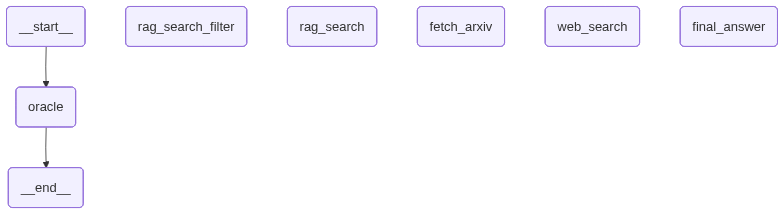

In [61]:
from IPython.display import Image, display

# Display the graph as a PNG using Mermaid rendering.
display(Image(runnable.get_graph().draw_mermaid_png()))

In [62]:
# Run the graph with input.
output = runnable.invoke({
    'input': 'Tell me something interesting about Dynamic Backtracking AI and LLMs',
    'chat_history': [],
})


run_oracle
intermediate_steps: []
rag_search.invoke(input={'query': 'Dynamic Backtracking AI'})
run_oracle
intermediate_steps: [AgentAction(tool='rag_search', tool_input={'query': 'Dynamic Backtracking AI'}, log='TBD'), AgentAction(tool='rag_search', tool_input={'query': 'Dynamic Backtracking AI'}, log='Title: MATRIX: Multimodal Agent Tuning for Robust Tool-Use Reasoning\nChunk: Preprint\ntrajectories, we combine two complementary components:step samplingandstep verification.\nInstead of relying on static demonstrations, we employ an online exploration scheme (Fig. 2)\nwhere the agent iteratively samples actions and verifies their quality within each task.\nAt stepi, the controller proposesncandidate actions{a1\ni,a2\ni,...,a n\ni}, each decomposed into\n(tk\ni,ck\ni), which are executed to yield observations{o1\ni,...,o n\ni}. We then prompt anLLM-based\nverifier with the queryQ, historyhi, candidate actions, and corresponding observations, and\nselect the most reliable action(t⋆\ni,c

## 16 - Generating Reports: Building a Formatted Final Report

In [63]:
def build_report(output: dict) -> str:
    '''Builds a formatted report based on the oracle's output.

    Args:
        output (dict): A dictionary containing the various sections of the report (graph's output).

    Returns:
        str: A formatted string containing the full research report.
    '''
    research_steps = output['research_steps']
    if isinstance(research_steps, list):
        research_steps = '\n'.join([f'- {r}' for r in research_steps])

    sources = output['sources']
    if isinstance(sources, list):
        sources = '\n'.join([f'- {s}' for s in sources])

    return f"""
        INTRODUCTION
        ------------
        {output['introduction']}

        RESEARCH STEPS
        --------------
        {research_steps}

        REPORT
        ------
        {output['main_body']}

        CONCLUSION
        ----------
        {output['conclusion']}

        SOURCES
        -------
        {sources}
    """


In [64]:
# Run the graph with input.
output = runnable.invoke({
    'input': 'Tell me something interesting about Dynamic Backtracking AI and LLMs',
    'chat_history': [],
})

output['intermediate_steps'][-1].tool_input

run_oracle
intermediate_steps: []
rag_search.invoke(input={'query': 'Dynamic Backtracking AI'})
run_oracle
intermediate_steps: [AgentAction(tool='rag_search', tool_input={'query': 'Dynamic Backtracking AI'}, log='TBD'), AgentAction(tool='rag_search', tool_input={'query': 'Dynamic Backtracking AI'}, log='Title: MATRIX: Multimodal Agent Tuning for Robust Tool-Use Reasoning\nChunk: Preprint\ntrajectories, we combine two complementary components:step samplingandstep verification.\nInstead of relying on static demonstrations, we employ an online exploration scheme (Fig. 2)\nwhere the agent iteratively samples actions and verifies their quality within each task.\nAt stepi, the controller proposesncandidate actions{a1\ni,a2\ni,...,a n\ni}, each decomposed into\n(tk\ni,ck\ni), which are executed to yield observations{o1\ni,...,o n\ni}. We then prompt anLLM-based\nverifier with the queryQ, historyhi, candidate actions, and corresponding observations, and\nselect the most reliable action(t⋆\ni,c

{'introduction': 'Dynamic Backtracking AI and Large Language Models (LLMs) are two fascinating areas in artificial intelligence that have garnered significant attention in recent years. Dynamic Backtracking offers a novel approach to solving complex search problems, while LLMs have revolutionized natural language processing and understanding.',
 'research_steps': "1. Conducted a RAG search for 'Dynamic Backtracking AI' to gather specialized information.\n2. Performed a web search to find general knowledge and recent developments on Dynamic Backtracking.\n3. Conducted a RAG search for 'LLMs in AI' to gather insights on the role of LLMs in AI advancements.",
 'main_body': 'Dynamic Backtracking is a sophisticated algorithmic technique that enhances traditional backtracking methods by allowing backtrack points to be moved deeper into the search space. This approach helps in avoiding the pitfalls of static backtracking, such as getting stuck in local optima or redundant paths. The technique

In [65]:
output = runnable.invoke({
    'input': 'tell me about FIFA World Cup 2030',
    'chat_history': []
})

report = build_report(
    output=output['intermediate_steps'][-1].tool_input
)

print(report)

run_oracle
intermediate_steps: []
web_search.invoke(input={'query': 'FIFA World Cup 2030'})
run_oracle
intermediate_steps: [AgentAction(tool='web_search', tool_input={'query': 'FIFA World Cup 2030'}, log='TBD'), AgentAction(tool='web_search', tool_input={'query': 'FIFA World Cup 2030'}, log="2030 FIFA World Cup\nThe 2030 FIFA World Cup will be the 24th FIFA World Cup, a quadrennial international football tournament contested by the men's national teams\nhttps://en.wikipedia.org/wiki/2030_FIFA_World_Cup\n---\nFIFA considering plan for 64-team World Cup in 2030\nThe 2030 World Cup not only could have its most number of teams ever, it is already set to be played on three continents and in six different ...\nhttps://www.reuters.com/sports/soccer/fifa-considering-plan-64-team-world-cup-2030--flm-2025-09-24/\n---\nWorld Cup 2030: FIFA, CONMEBOL leaders discuss 64- ...\nFIFA President Gianni Infantino and CONMEBOL President Alejandro Domínguez met in New York to discuss expanding the 2030 men

In [66]:
output = runnable.invoke({
    'input': 'Create a summary about the future of LLM & Rag Reasoning.',
    'chat_history': []
})

report = build_report(
    output=output['intermediate_steps'][-1].tool_input
)

print(report)

run_oracle
intermediate_steps: []
rag_search.invoke(input={'query': 'future of LLM and RAG reasoning'})
run_oracle
intermediate_steps: [AgentAction(tool='rag_search', tool_input={'query': 'future of LLM and RAG reasoning'}, log='TBD'), AgentAction(tool='rag_search', tool_input={'query': 'future of LLM and RAG reasoning'}, log='Title: ArenaBencher: Automatic Benchmark Evolution via Multi-Model Competitive Evaluation\nChunk: on this objective and in-context demonstrations of strong candidates evaluated by multi-model feed-\nback, the generator iteratively proposes multiple candidate queries and answers, and an independent\nLLM judge verifies correctness and test target alignment.\n2021) for grade-school math and Winogrande (Sakaguchi et al., 2021) for pronoun resolution. More\ncomprehensive benchmarks aggregate a diverse set of tasks to provide holistic evaluations, including\nMMLU (Hendrycks et al., 2020) for academic knowledge, BIG-bench (Srivastava et al., 2023) for\nbroad capability 